# 概要

このノートブックでは,
pytorchを用いてGANの実装を行う.

In [1]:
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()
train_X, test_X = train_X.reshape(train_X.shape[0], -1), test_X.reshape(test_X.shape[0], -1)
train_Y, test_Y = train_Y.reshape(-1), test_Y.reshape(-1)
train_X, test_X = train_X/255, test_X/255

## Generative Adversarial Network (GAN)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Model(nn.Module):
    def __init__(self, *structure):
        super().__init__()
        self.depth = len(structure)
        self.units = structure
        
        for i in range(self.depth-1):
            layer = nn.Linear(self.units[i], self.units[i+1])
            nn.init.kaiming_normal_(layer.weight, mode="fan_in", nonlinearity="relu")
            setattr(self, f'fc{i+1}', layer)
            
    def forward(self, x):
        out = x
        for i in range(self.depth-2):
            out = F.relu(getattr(self, f'fc{i+1}')(out))
        return torch.sigmoid(getattr(self, f'fc{self.depth-1}')(out))

In [5]:
from tqdm import tqdm
import time
class Solver(object):
    def __init__(self, max_epoch = 100, batch_size = 128, g_structure=[100, 300, 500, 784], d_structure=[784, 1024, 1024, 1]):
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
        else:
            self.device = torch.device("cpu")
        
        self.G = Model(*g_structure).to(self.device)
        self.D = Model(*d_structure).to(self.device)
        self.g_structure = g_structure
        self.d_structure = d_structure
        self.g_optimizer = torch.optim.Adam(self.G.parameters())
        self.d_optimizer = torch.optim.Adam(self.D.parameters())
        
        self.criterion = nn.BCELoss()
        
    def fit(self, train_X):
        self.g_loss = []
        self.d_loss = []
        for epoch in tqdm(range(self.max_epoch)):
            time.sleep(0.1)
            g_loss, d_loss = self._epoch_procedure(train_X)
            self.g_loss.append(g_loss)
            self.d_loss.append(d_loss)
            
    def _epoch_procedure(self, train_X):
        self.G.train()
        self.D.train()
        loader = torch.utils.data.DataLoader(torch.from_numpy(train_X).to(self.device), batch_size=self.batch_size, shuffle=True)
        
        running_d_loss = 0.0
        running_g_loss = 0.0
        for idx, (inputs) in enumerate(loader):
            inputs = Variable(inputs).float()
            real_label = torch.ones(inputs.size(0)).view(-1,1).float()
            fake_label = torch.zeros(inputs.size(0)).view(-1,1).float()
            z = np.random.normal(0.0, 1.0, (inputs.size(0), self.g_structure[0]))
            z = torch.from_numpy(z).to(self.device)
            z = Variable(z).float()
            
            #Update Discriminator
            real_loss = self.criterion(self.D(inputs), real_label)
            gen_inputs = self.G(z)
            fake_loss = self.criterion(self.D(gen_inputs), fake_label)
            
            total_loss = real_loss+fake_loss
            running_d_loss+=total_loss.item()
            self.d_optimizer.zero_grad()
            total_loss.backward()
            self.d_optimizer.step()
            
            #Update Generator
            gen_inputs = self.G(z)
            loss = self.criterion(self.D(gen_inputs), real_label)
            running_g_loss+=loss.item()
            self.g_optimizer.zero_grad()
            loss.backward()
            self.g_optimizer.step()
        return running_g_loss/len(loader), running_d_loss/len(loader)
    
    def gen_data(self, num=100):
        self.G.eval()
        z = np.random.normal(0.0, 1.0, (num, self.g_structure[0]))
        z = torch.from_numpy(z).to(self.device)
        z = Variable(z).float()
        gen_inputs = self.G(z)
        return gen_inputs.cpu().data.numpy()

In [6]:
solver = Solver(g_structure=[100, 300, train_X.shape[1]], d_structure=[train_X.shape[1], 1024, 1])

In [7]:
solver.fit(train_X)

100%|██████████| 100/100 [55:39<00:00, 43.36s/it]


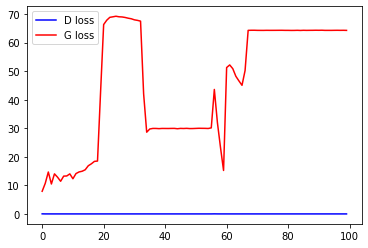

In [8]:
plt.figure()
plt.plot(solver.d_loss, 'blue',label="D loss")
plt.plot(solver.g_loss, 'red', label="G loss")
plt.legend()
plt.show()
plt.close()

In [9]:
gen_x = solver.gen_data(num=10)

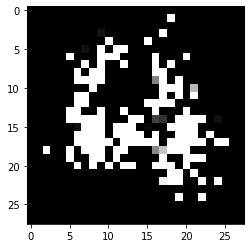

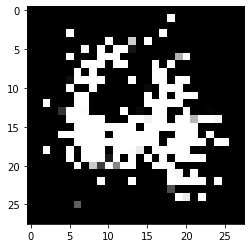

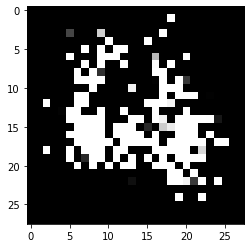

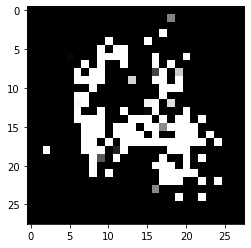

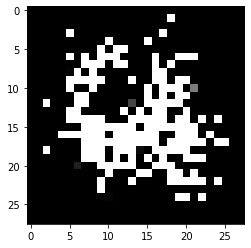

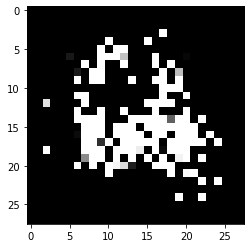

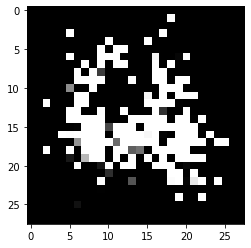

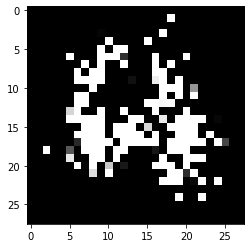

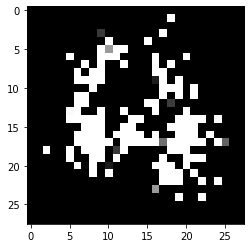

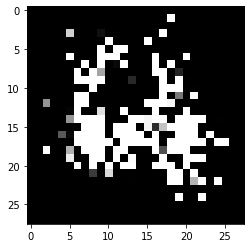

In [10]:
for i in range(gen_x.shape[0]):
    plt.plot()
    plt.imshow(gen_x[i].reshape(28,28))
    plt.gray()
    plt.show()
    plt.close()